# Apllication of Scasat to Buenrostro data

This is the python notebook that uses __S__ingle-__c__ell __A__TAC-seq __A__nalysis __T__ool (Scasat) to process single cell ATAC-seq data from [_Buenrostro et. al._](https://www.nature.com/articles/nature14590) which is publicly available. In this anlaysis we only used the human data from this public data.

__Prerequisites:__

In order to use Scasat, you have to have the following tools installed in the machine where you are running Scasat
1. [samtools](http://www.htslib.org)
2. [bedtools](http://bedtools.readthedocs.io/en/latest/)
3. [macs2](https://github.com/taoliu/MACS)

If you are using jupyter from anaconda installation then you can install the tools with the following command
* samtools: conda install -c bioconda samtools
* bedtools: conda install -c bioconda bedtools 
* macs2: conda install -c bioconda macs2 (please note that macs2 only runs on python2.7 so you have to create a python2.7 environment if you are using python3

This jupyter notebook introduces __S__ingle-__c__ell __A__TAC-seq __A__nalysis __T__ool (Scasat) to deconvolute three cell types from a complex cell mixture. Scasat analyses single cell ATAC-seq data to identify regulatory regions that separates cells from a complex population. This notebook is the tool mentioned in [___Murtuza Baker et. al.___]()

### Import python packages

We import the python packages.

In [2]:
import subprocess, os, csv, signal, rpy2
import numpy as np
import readline
import rpy2.robjects
import matplotlib.pyplot as plt
import csv
from operator import itemgetter
%matplotlib inline

This code toggles between showing/hiding the codes. The outputs and the discussions would always be visible.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



rpy2 package provides a simple and robust access to `R` from within `Python`. The following cells loads the package to run `R` code within `Python` notebook. To write and execute `R` code we will use the magic command `%%R` at the top of the cell. 

In [3]:
%load_ext rpy2.ipython

## Python Functions

Below we define the python functions for Scasat. One of the advantage of Scasat is the use of both python and R programming language. We use python for file processing and R for doing the data analysis.

In [4]:
def formatSummitBed(summitFile, fileToSave):
#fileToSave = 'location_toSave/AllFiles_Filtered_summits_shifted.bed' 
#peakFile = 'location_PeakFile/AllFiles_Filtered_summits.bed'

    with open(summitFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    for i in range(len(peaks)):
        peaks[i][1] = str(int(peaks[i][1]) - 250)
        peaks[i][2] = str(int(peaks[i][2]) + 250)

    peaks.sort(key=lambda x: float(x[4]), reverse=True)

    with open(fileToSave, "w") as f:
        writer = csv.writer(f,delimiter='\t')
        writer.writerows(peaks)

`formatSummitBed()`: 
> This functions formats the summit file by adding 500 bp distance from the summit position.

Arguments:
> `summitFile` : The name of the summit file. This has to be the file that is generated from the aggreagated `BAM` file<br>
> `fileToSave`: The name of the file where the save the peak file with the 500 bp peaks.

Value:
> File with 500 bp peaks.

In [5]:
def getMergedBam(BAMFolder, BAMFilePattern):
    
    import pandas as pd
    
        
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith(BAMFilePattern))]
            for f in files:
                mergeFiles = mergeFiles +  f + ' '
    
        
    mergeCommand = 'samtools merge ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' + mergeFiles    
    subprocess.call(mergeCommand, shell=True)   
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam'
    subprocess.call(indexMergeCmd, shell=True)
    
    cleanCommand = 'samtools view -b ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' \
                    + 'chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14' \
                    + ' chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX  > ' \
                    + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'
    subprocess.call(cleanCommand, shell=True)            
    
    sortMergeCmd = 'samtools sort -o ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' \
                    + ' ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'        
    subprocess.call(sortMergeCmd, shell=True)
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam'
    subprocess.call(indexMergeCmd, shell=True) 

`getMergedBam()`:
> merges all the individual `BAM` files for each of the cells and creates `AllFiles_Filtered_Merged_nodup.bam` file. This file is then sorted and indexed.

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> The merged `BAM` file `AllFiles_Filtered_Merged_nodup_sorted.bam`. 

In [6]:
def getAggregatedPeak(BAMFolder, BAMFilePattern):
    getMergedBam(BAMFolder, BAMFilePattern)
    
    MergedMacs2Cmd = '/home/mqbsxsm2/anaconda3/envs/python2/bin/macs2 callpeak -t ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' +' -n ' \
                    + BAMFolder + 'AllFiles_Filtered' +' -q 0.2 -g hs -f BAMPE --nomodel --nolambda \
                    -B --call-summits --keep-dup all; source deactivate'
    subprocess.run(MergedMacs2Cmd, shell=True)
    
    narrowPeakFile = BAMFolder + 'AllFiles_Filtered_peaks.narrowPeak'
    mergedPeakFile = BAMFolder + 'mergedPeaks.bed'
    tmpPeakFile = BAMFolder + 'tmpPeak.txt'
    
    
    with open(narrowPeakFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    peaks.sort(key=lambda x: float(x[8]), reverse=True)
    
    
    peaksToWrite = list()
    for i in range(len(peaks)):
        peaksToWrite.insert(i, peaks[i][0:4])
        peaksToWrite[i].append(peaks[i][8])      
    
    
    with open(mergedPeakFile, "w") as f:
        writer = csv.writer(f,delimiter='\t')        
        writer.writerows(peaksToWrite)        
        
    sortCmd = 'sort -k1,1 -k2,2n ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)
    
    bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 5 -o last > ' + mergedPeakFile
    subprocess.call(bedToolsCmd, shell=True)
    
    sortCmd = 'sort -nrk4 ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)    
    
    copyCmd = 'cat ' + tmpPeakFile + ' > ' + mergedPeakFile
    subprocess.call(copyCmd, shell=True)    

`getAggregatedPeak()`:
> This function calls `MACS2` on the aggregated `BAM` file and generates the peaks. If the user is following the merging BAM option then this is the function they need to call. Then the `getMergedBam()` is called within this function

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> Peak files from MACS2 call.

------------------
## R functions

### Loading R packages (if not available it will install it before loading)

Pleae note that inorder to install `GenomicFeatures` the mysql library has to be alreay installed. If it is not available in your system the use the following command to install it

`sudo apt-get install libdbd-mysql libmysqlclient-devthe`

In [59]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, GenomicFeatures, ComplexHeatmap, Rtsne, prabclus, GGally, rtracklayer, corrplot, 
               cluster, EnsDb.Hsapiens.v75, ChIPpeakAnno, org.Hs.eg.db, rGREAT, marge, tidyverse, tibble)

### R functions for the Scasat

Now I define all the R functions. These functions will be used for most of the downstream analysis. A short explanation of each function along with its input and output are also given below of each function. 

In [9]:
%%R
peakAccessibility <- function(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName){
    if(length(list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE))>0){
        files = list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE)
        unlink(files)
    }
    formatingToBed(peakFolder, peakFilePattern, outputFolder)
    peakFilePattern = paste0(peakFilePattern,'.bed')
    query = import(mergedPeakFile)
    queryDF <- data.frame(query)
    #queryDF <- queryDF[order(queryDF$name, decreasing=TRUE),]    
    
    totalOverlap <- data.frame(seqnames = queryDF$seqnames, start = queryDF$start, end = queryDF$end)    
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    cellName <- list.files(path=peakFolder, pattern = peakFilePattern)
    for (i in 1:length(files)){
        subject = import(files[i])
        hits = findOverlaps(query, subject)
        hitsDF <- data.frame(hits)
        cellName[i] <- gsub(peakFilePattern, '', cellName[i])
        totalOverlap[hitsDF$queryHits, cellName[i]] <- 1
        totalOverlap[-hitsDF$queryHits, cellName[i]] <- 0
    }
    outputFile = paste0(outputFolder,outputPeakFileName)
    write.table(totalOverlap, outputFile, row.names=FALSE)    
}    


`peakAccesibility()`:
> This function calculates the accessible peaks for each of the cells. It looks at each of the peaks listed in _Aggregated-Peak_ table and tries to find out whether there is any overlap between these peaks and the peaks of each cell. If there is then it puts a 1 agains that cells for that peak. Otherwise it puts 0. Calling these function for each of the cell completes the _Aggregated-Peak_ for which rows represnt all the peaks and the column represents cells.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed` file that were generated while calling `mergePeaks()` python function.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved
> `outputPeakFileName`: Name of the file where the peak accessibility table, _Aggregated-Peak_ would be saved. This file will contain all the accessibility information for all the cells.


Value:
> Peak accessibile table saved according to the name set in `outputPeakFileName`. The table will have the results in 1 or 0 expression peak opening or closing respectively.

In [10]:
%%R
formatingToBed <- function(peakFolder, peakFilePattern, outputFolder){
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    for (i in 1:length(files)){
        narrowPeak <- read.csv(files[i], header=FALSE, sep='\t')
        write.table(narrowPeak[,1:4], paste0(files[i],'.bed'), 
                    row.names=FALSE, sep='\t', col.names=FALSE, quote=FALSE)
    }
}

`formatingToBed()`:
> This function formats the bed file suitable for processing by ScAsAT. It adds a `.bed` extension at the end.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed` file that were generated while calling `mergePeaks()` python function.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved

Value:
> Formats the bed files with adding a `.bed` extesion.

In [11]:
%%R
calcEntropy <- function(data){
	freqs <- table(data)/sum(table(data))
	return(-sum(freqs * log(freqs)))
}

`calcEntropy()`:
> Calcuates entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$


`Usage`:
> `calcEntropy(count_data)`

Arguements:
> `count_data`: The peak information converted into binary. 

Value:
> Returns entropy of the count data.

In [12]:
%%R
getDiffAccessInformationGain <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]
    
    CellType <- data.frame(CellType=gsub('_.*','',names(groups)))
    
         
    SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1.Binary,SingleCell.Group2.Binary)
    SingleCell.Group1VsGroup2 <- t(SingleCell.Group1VsGroup2)
    #SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1VsGroup2,CellType)   

    
    dataDim = (dim(SingleCell.Group1VsGroup2)[2])
    #dataDim = 5
    
    information.gain = vector(mode="numeric", length=(ncol(SingleCell.Group1VsGroup2)-1))
    SingleCell.Group1VsGroup2.res <- data.frame(Chr = cdBinary[1:dataDim,1],
                                           Start = cdBinary[1:dataDim,2],
                                           end = cdBinary[1:dataDim,3])        
    
    
    for(i in 1:dataDim)
    {
        jointData = cbind(SingleCell.Group1VsGroup2[,i], CellType)
        
        gain <- calcEntropy(jointData[,2]) - 
                (sum(table(jointData)[c(1,3)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==0,]) - 
                (sum(table(jointData)[c(2,4)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==1,])
        SingleCell.Group1VsGroup2.res$information.gain[i] <- gain        
    }
    
        
    SingleCell.Group1.rawAvg <- rowSums(SingleCell.Group1.Binary==1)/dim(SingleCell.Group1.Binary)[2]
    SingleCell.Group2.rawAvg <- rowSums(SingleCell.Group2.Binary==1)/dim(SingleCell.Group2.Binary)[2]
    
    SingleCell.Group1VsGroup2.res$rawMeanGroup1 <- SingleCell.Group1.rawAvg
    SingleCell.Group1VsGroup2.res$rawMeanGroup2 <- SingleCell.Group2.rawAvg
    SingleCell.Group1VsGroup2.res$log2FoldChange <- log2(SingleCell.Group1VsGroup2.res$rawMeanGroup1/
                                                       SingleCell.Group1VsGroup2.res$rawMeanGroup2)
    

    #write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$information.gain, decreasing=TRUE),], 
    #          paste0(levels(groups)[1],'_vs_',levels(groups)[2],'InformationGain.csv'), row.names=FALSE)
    
    SingleCell.Group1VsGroup2.res <- SingleCell.Group1VsGroup2.res[!is.nan(SingleCell.Group1VsGroup2.res$information.gain) &
                                                                  !is.na(SingleCell.Group1VsGroup2.res$information.gain),]
    
    return(SingleCell.Group1VsGroup2.res)    
}

`getDiffAccessInformationGain()`:
> Caculates differential accessibility between two groups of cells using entropy and information gain. For each peak the accessibility is encoded as a binary variable. For each peak we calculate the "Information gain" by having the peak divided into two groups of cells for which we are trying to find out the differential accessibilty. The Information gain is calculated as

$$ 
 Gain(P, P_{G_1}, P_{G_2}) = Entropy(P) - \sum_{v \epsilon\{G_1,G_2 \}} \frac{|P_v|}{|P|}Entropy(P_v)
$$

>where Entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$

> The peaks are then sorted based on the informatin gain and the user can choose the cutoff value for selecting the DA peaks. A suggested value for this would be values < 0.01


`Usage`:
> `getDiffAccessLogsitic(count_data, groups)`

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

>`groups` : groups into which each cell belong to.

Value:
> Returns a table with the peaks along with Information gain.

In [13]:
%%R
getDiffAccess <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]

    SingleCell.Group1.ZeroCount <- rowSums(SingleCell.Group1.Binary==0)
    SingleCell.Group2.ZeroCount <- rowSums(SingleCell.Group2.Binary==0)
    SingleCell.Group1.OneCount <- rowSums(SingleCell.Group1.Binary==1)
    SingleCell.Group2.OneCount <- rowSums(SingleCell.Group2.Binary==1)
    
    SingleCell.Group1VsGroup2 <- data.frame(Chr = cdBinary[,1],
                                           Start = cdBinary[,2],
                                           end = cdBinary[,3])

    SingleCell.Group1VsGroup2$group1OneCounts <- SingleCell.Group1.OneCount
    SingleCell.Group1VsGroup2$group2OneCounts <- SingleCell.Group2.OneCount
    SingleCell.Group1VsGroup2$log2Fold <- log2((SingleCell.Group1.OneCount+1)/dim(SingleCell.Group1.Binary)[2]) - 
                                            log2(((SingleCell.Group2.OneCount+1)/dim(SingleCell.Group2.Binary)[2]))
    pvalue = vector(mode="numeric", length=length(SingleCell.Group2.OneCount))
    nGenes <- nrow(SingleCell.Group1.Binary)
    
    
    for(i in 1:length(SingleCell.Group2.OneCount))
    {
        contingencyTable <- matrix(c(SingleCell.Group1.ZeroCount[i], SingleCell.Group2.ZeroCount[i],
                                     SingleCell.Group1.OneCount[i], SingleCell.Group2.OneCount[i]), ncol=2)
        SingleCell.Group1VsGroup2$pvalue[i] <- fisher.test(contingencyTable)$p.value        
    }
    
    # Bonferroni correction
    SingleCell.Group1VsGroup2$p_adjust <- p.adjust(SingleCell.Group1VsGroup2$pvalue, method="bonferroni")

    write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$p_adjust, decreasing=FALSE),], 
              paste0(levels(groups)[1],'_vs_',levels(groups)[2],'.csv'), row.names=FALSE)
    
    return(SingleCell.Group1VsGroup2)    
}

`getDiffAccess()`:
> Caculates differential accessibility between two groups of cells. For each peak it creates a contingency table with number of 0's and 1's for the two groups. <br>

>|               	| Group-1 	| Group-2 	|
|---------------	|---------	|---------	|
| Number of 0's 	|         	|         	|
| Number of 1's 	|         	|         	| 
<br>
It then runs Fisher exact test to calculate the p-values. These p-values are then corrected for multiple testing with Bonferroni correction. Finally the function returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

Value:
> Returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

In [14]:
%%R
getPeakVsPrecision <- function(peakA, peakB,start=100,stepSize=100){
    
    if (colnames(peakA)[1] != 'chr' | colnames(peakA)[2] != 'start' | colnames(peakA)[3] != 'end') {
        stop(paste("ERROR: Column name should have 'Chr' 'Start' 'End'"))
    }

    dimToRun <- min(dim(peakA)[1],dim(peakB)[1])
    if(dim(peakB)[1]>dimToRun){
        peakB <- peakB[1:dimToRun,]
    }
    GenomicRangeObjA <- makeGRangesFromDataFrame(peakA,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)
    j=1
    Recall <- vector(mode="numeric", length=0)
    Precision <- vector(mode="numeric", length=0)
    for(i in seq(100,(dimToRun-stepSize),stepSize)){
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[1:i,],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)

           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)
           
           FP = dim(peakB[1:i,])[1] - length(intersectRes)
           TP = length(intersectRes)
           
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[(i+1):dim(peakB)[1],],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("Chr"),
                         start.field="Start",
                         end.field=c("End"),
                         starts.in.df.are.0based=FALSE)
                         
           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)

           TN = dim(peakB[(i+1):dim(peakB)[1],]) - length(intersectRes)
           FN = length(intersectRes)
           Recall[j] = 100*(TP/(TP + FN))
           Precision[j] = 100*(TP / (TP + FP))
           j = j +1
           
   
    }
    df<-data.frame(x=Recall,y=Precision)
    p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    
    p <- p + ggtitle("Recall vs Precision") + theme(plot.title = element_text(size = 16, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Recall%") 
    p <- p + ylab("Precision%")+
	theme_light(base_size=15) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    print(p)
    
    GenomicRangeObjB <- makeGRangesFromDataFrame(peakB,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("Chr"),
                         start.field="Start",
                         end.field=c("End"),
                         starts.in.df.are.0based=FALSE)
                         
     write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
     write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
     bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
     intersectRes = system(bedToolsCmd, intern=TRUE)
   
   return(intersectRes) 
}

`getPeakVsPrecision()`:
> This function is used to see how many peaks from the Bulk data the single-cell have been able to capture. For that we calculate the Peak and the Precision of the single-cell data against its Bulk counterpart and then plot it. The way these two values are calculated are

$$
Recall = 100  \frac{TP}{TP + FN}
$$
$$
Precision = 100  \frac{TP}{TP + FP}
$$
> where <br>
> TP = True Positive <br>
> TN = True Negative <br>
> FP = False Positive <br>
> FN = False Negative <br>

`Usage`:
> `getPeakVsPrecision(peakA, peakB,start,stepSize)`

Arguements:
> `peakA`: Peak of the BULK data <br>
> `peakB`: Single-cell Peak <br>
> `start`: Number of peaks to start with the calculation, default is `100`. <br>
> `stepSize`: Size of the increase steps

Value:
> Plots Recall vs. Precision and returns a summary

In [15]:
%%R
getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}

`getJaccardDist()`:
> This function calculates the jaccard distance between each of the cells. Jaccard distance calculates the ratio between the differences of the sizes of the union and intersection against the size of the union. The equation for calculating this distance is <br><br>$$d_J(A,B)=\frac{|A \cup B| - |A \cap B|}{|A \cup B|}$$

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. 


Value:
> Jaccard distance between each of the cell.

In [16]:
%%R
plotMDS <- function(cdBinary, k, groups=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title=""){

    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p <- ggplot(df, aes_string(x="x",y ="y", color="Batch"))
            #scale_colour_hue(l=40)
            #scale_fill_manual(values = getPalette(15))
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 4)
    p <- p + xlab("Cordinate 1") 
    p <- p + ylab("Codinate 2")+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

       
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    #p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14),
    #legend.text = element_text(size = 14), legend.title = element_text(size = 14))
    
    print(p)
    
    if(ret.val == TRUE)
        return(fit)
}

`plotMDS()`:
> This function calculates the Multidimensional Scaling (MDS) and plots the cells based on Jaccard distance to visualize the level of similarity between the cells.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`k`: The maximum dimension of the space which the data are to be represented in; must be in {1, 2, ..., n-1}. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`cellName`: If `text.label` is set to `TRUE` then you have to supply `cellName`.
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.


Value:
> Calculates the MDS and plots the cells based on their MDS dimension. It returns the MDS values if `ret.val` is set to TRUE.

In [17]:
%%R
plotPCAJaccard <- function(cdBinary, groups=NULL, ret.val=FALSE , cellName, text.label=FALSE, title){
    
   
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)
    percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
 
    if(is.null(groups)){
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY"))        
    }
    else{
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy], groups=groups)
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY", color="groups"))             
    }          
    if(missing(title))
        p1<-p1+ggtitle("PCA with Jacard Matrix")
    else
        p1<-p1+ggtitle(title)
        
    p1<-p1+geom_point(size = 3)
    p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
    p1<-p1+ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
    if(text.label == TRUE){
        p1<-p1+geom_text(data=df,aes(label=cellName),
                       alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
    }
    
    p1<-p1 +
    theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())

    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    
    print(p1)
        
    if(ret.val == TRUE)
        return(pcaPRComp)
}

`plotPCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) and plots the cells based on Jaccard distance in a reduced dimension to visualize how the cells cluster together.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in reduced dimension. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [18]:
%%R
plotMultiplePCAJaccard <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){
    
    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)


    if(is.null(groups)){
        df <- as.data.frame(pcaPRComp$x)
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle,              
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
    	     theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))        
    }
    else{
        df <- as.data.frame(pcaPRComp$x)
        df$Cell=groups        
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle, 
             mapping = aes_string(color="Cell"),
             legend = c(1,nPCAToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
             theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))
    }          
    
    print(p)
}

`plotMultiplePCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) based on Jacard distance and plots the first `n` components of the PCA.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in first `n` components. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [19]:
%%R
plotVarExplained <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent","PC_Var_n_percent")


    p <- ggplot(pca_var_out[1:nmax,]) + scale_colour_hue(l=40) 
    p <- p + geom_line(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:nmax))+
         scale_colour_brewer(palette="Set1")
         
   print(p)
}

`plotVarExplained()`:
> This function calculates the percent of variance explained by the PCAs and plots it.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates the percent of variance explained by the PCAs and the plots thsoe percentage. 

In [20]:
%%R
plot_tSNE <- function(cdBinary, nDimToUSE, groups=NULL, cellName, perplexity_division, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nDimToUSE)){
    	stop("ERROR: Number of PCA's \"nDimToUSE\" to use is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    if(missing(perplexity_division)){
        stop("ERROR: Please enter the number with which you want to divide the dimension of your data for perplexity setting")
    }
        
    
    #SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    #FinalPCAData <- t(SingleCell.Binary.Jaccard)
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=nDimToUSE)

    #pcaPRComp <- prcomp(FinalPCAData)

    
    #rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:nPCAToUSE]), perplexity = dim(pcaPRComp$x)[1]/perplexity_division, check_duplicates = FALSE)
    rtsne_pca_out <- Rtsne(as.matrix(fit$points[,1:nDimToUSE]), perplexity = perplexity_division, 
                           check_duplicates = FALSE, pca=FALSE, theta=0.01, max_iter=3000)
    
    if(is.null(groups)){
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2])
        p1 <- ggplot(df, aes_string(x="X",y ="Y"))
    }
    else{
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups, cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Batch"))
    }
    

    p1<-p1 + ggtitle("t-SNE plot")
    p1<-p1 + geom_point(size = 2) 
    p1<-p1 + xlab(paste("Dim-1"))
    p1<-p1 + ylab("Dim-2")+
        theme_light(base_size=15) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    if(text.label==TRUE)
        p1<-p1 + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p1)
    return(df)
}

`plot_tSNE()`:
> Caculates the t-distributed stochastic neighbor embedding (t-SNE) which is a non-linear dimensionality reduction technique particualrly suitable for embedding high-dimensional data into a space of two or three dimensions. This function then plots the lower dimensional representation of the cells in a 2-D scatter plot.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to be used to calcualte the t-SNE values. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates and plots the t-SNE representation of the cells. 

In [21]:
%%R
clean.count.peaks <- function(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50){
    cdFilt <- cd[,1:3]
    cdCells <- cd[,4:dim(cd)[2]]
    valid.cell.ix <- which(colSums(cdCells) >= min.peaks.cell)
    cdFilt <- cbind(cdFilt,cdCells[,valid.cell.ix])
    cdFilt <- cdFilt[rowSums(cdFilt[,4:dim(cdFilt)[2]]) >=min.cell.peaks.obs ,]
    cdFiltTemp <- cdFilt[,1:3]
    cdCells <- cdFilt[,4:dim(cdFilt)[2]]
    valid.cell.ix <- which(colSums(cdCells) > 0)
    cdFilt <- cbind(cdFiltTemp,cdCells[,valid.cell.ix])
    return(cdFilt)
}

`clean.count.peaks()`:
> This function filter peaks and cells based on peak and cell requirements.

Usage:
> `clean.count.peaks(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50)`

Arguements:
> `cd`: A binay matrix with the peak accessiblity of all the single-cells. The row would reprsent each of the peaks unique name and the columns would be each cell. Each entry in the matrix is 0/1 representing either the peak is close/open for that cell. <br>
> `min.cell.peaks.obs`: Minimum number of cells that a peak has to be observed in order for that peak to be a valid peak. <br>
> `min.peaks.cell` : Minimum number of peaks that a cell needs to have in order for that cell to be called a valid cell. <br>

Value:
> A matrix with valid accessible peaks.

In [22]:
%%R
multiplot <- function(..., plotList=NULL, File, cols=1, layout=NULL) {

  # Adopted from Cookbook for R
  library(grid)

  plots <- c(list(...), plotList)

  numPlots = length(plots)

  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

--------------

# Analysis
Below we start the analysis with Buenrostro data. 

### Configuration Cell
Following is the cell where we configure all the parameters for the tool.

In [23]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are. This has to be the folder
# where each of the individual cells peak files reside
peakFolder = '/home/mqbsxsm2/my-scratch-share/Buenrostro_pipeline_Final/Human_data_analysis/output/Filtered_Macs2_files'


# Set this parameter to the folder where the peaks for the merge files are. This can be the same folder
# of all the individual cells peak folder or can be a single peak file that is generated from merging BAM files
peakFolderToMerge = '/home/mqbsxsm2/my-scratch-share/Buenrostro_pipeline_Final/Human_data_analysis/output/Bam_Files_Filtered_on_Library_Size/'



# Set up the pattern for the BAM file ending
BAMFilePattern = '_nodup_sorted_cleaned.bam'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = '/home/mqbsxsm2/my-scratch-share/Buenrostro_pipeline_Final/Human_data_analysis/output/Bam_Files_Filtered_on_Library_Size/mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = peakFolderToMerge

# Set the outputPeakFileName name here
outputPeakFileName = 'All_Human_Bam_NoTrimmo_NoShift.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName

We now call `getAggregatedPeak()` to merge all the BAM files and generated the aggregated peak from the merged BAM file.

In [28]:
getAggregatedPeak(peakFolderToMerge, BAMFilePattern)

To calculates the accessiblity of each of the peaks for all the cells we call the following function.

In [29]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccessibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

Reading the peak files

In [38]:
%%R
peakFile <- 'All_Human_Bam.csv'
cd <- read.csv(peakFile, sep=' ', header=TRUE)

In [24]:
%%R -i peakFile
cd <- read.csv(peakFile, sep=' ', header=TRUE)

In [25]:
%%R
dim(cd)

[1] 113343    743


## Filtering accessible peaks

Now we filter all the low quality cells and peaks.

As there are 740 cells we would consider a cell to be a valid cell if it has at least 114 peaks (at least 0.1% of the total peaks). Also a peak is valid peak to be valid if it is observed in at least 2% of the cells.

In [26]:
%%R
cdFilt <- clean.count.peaks(cd,min.peaks.cell = 114, min.cell.peaks.obs = 15)
print(dim(cd))
print(dim(cdFilt))
cdFiltTop <- cdFilt

[1] 113343    743
[1] 32241   743


In [178]:
%%R
write.csv(cdFiltTop, 'cdTop_Buenrostro_updated.csv', sep='\t')

In [27]:
%%R
colnames(cdFiltTop) <- gsub('_.*','',colnames(cdFiltTop))

In [28]:
%%R
head(colnames(cdFiltTop))

[1] "seqnames"   "start"      "end"        "SRR1779589" "SRR1779592"
[6] "SRR1779594"


Read annotation file

In [29]:
%%R
annot <- read.csv('sraAnnotWithSpecies.csv')
rownames(annot) <- annot$run_accession
head(annot)

           run_accession organism_ch1     CellInfo
SRR1779587    SRR1779587 Homo sapiens H1ESC-well-1
SRR1779588    SRR1779588 Homo sapiens H1ESC-well-2
SRR1779589    SRR1779589 Homo sapiens H1ESC-well-3
SRR1779590    SRR1779590 Homo sapiens H1ESC-well-4
SRR1779591    SRR1779591 Homo sapiens H1ESC-well-5
SRR1779592    SRR1779592 Homo sapiens H1ESC-well-6


In [30]:
%%R
annotFilt <- annot[colnames(cdFiltTop[,4:dim(cdFiltTop)[2]]),]
dim(annotFilt)

[1] 740   3


In [31]:
%%R
write.csv(annotFilt,'sraAnnotWithSpeciesFilteredList.csv')

In [32]:
%%R
Batches <- levels(as.factor(sub('-.*','',annotFilt$CellInfo)))
Batches

[1] "BJ"    "GM"    "H1ESC" "HL60"  "K562"  "TF1"  


In [33]:
%%R
cellNames <- colnames(cdFiltTop[,4:dim(cdFiltTop)[2]])
cellTypes <- as.factor(sub('-well.*','',annotFilt$CellInfo))
#cellTypes <- as.factor(gsub('[0-9]','',colnames(cdFiltTumorTopSel[,4:dim(cdFiltTumorTopSel)[2]])))


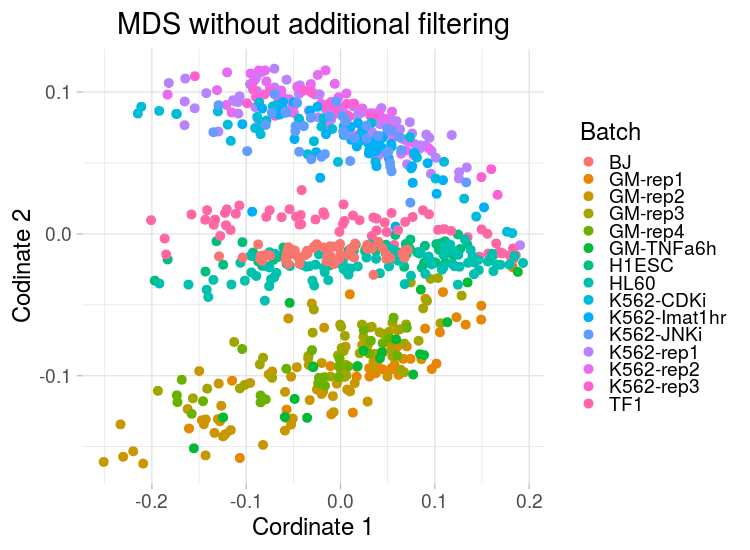

In [34]:
%%R -w 750 -h 550
#pdf('MDS_with_batch_effect.pdf')
MDSClust <- plotMDS(cdFiltTop, 4, groups=cellTypes, ret.val=TRUE, text.label=FALSE, title="MDS without additional filtering")
#dev.off()

The cells largeley seprate based on the cell types although no obvous cluster comes up.

In [35]:
%%R
cellTypesRepComb <- as.factor(sub('-.*','',annotFilt$CellInfo))

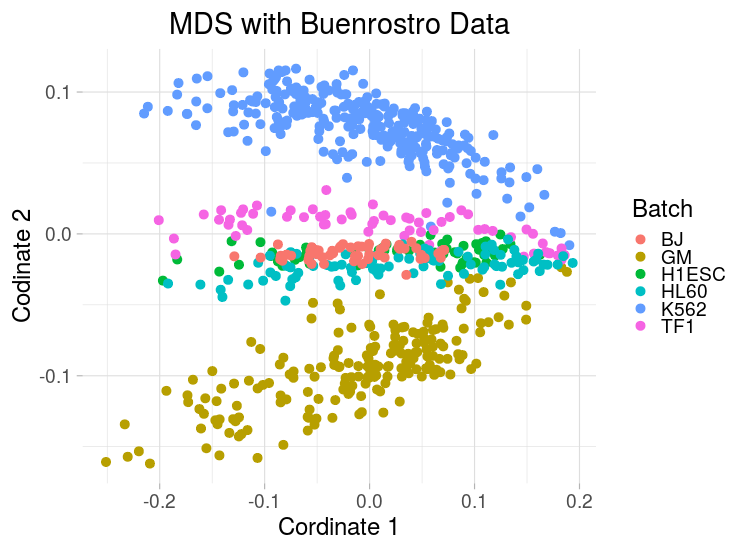

In [36]:
%%R -w 750 -h 550
#pdf('MDS_with_Buenrostro_data.pdf')
MDSClust <- plotMDS(cdFiltTop, 4, groups=cellTypesRepComb, ret.val=TRUE, text.label=FALSE, title="MDS with Buenrostro Data")
#dev.off()

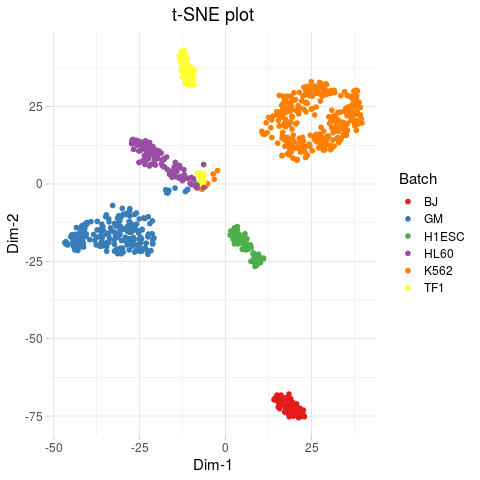

In [37]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 14, groups=cellTypesRepComb, perplexity=30, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

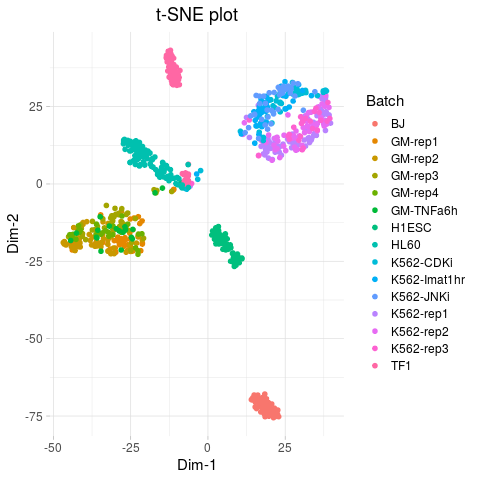

In [38]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 14, groups=cellTypes, perplexity=30, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

## Clustering
Now I would do clustering of the cells. I will use the `dynamicTreeCut` method for which I do not need to mention the number of clusters beforehand.

In [39]:
%%R
my.dist <- as.dist(getJaccardDist(cdFiltTop))

In [40]:
%%R
#chosen.exprs <- as.matrix(cdTmpIndex)
#my.dist <- dist(t(chosen.exprs), method="binary")
my.tree <- hclust(my.dist, method = "ward.D2")


library(dynamicTreeCut)
my.clusters <- unname(cutreeDynamic(my.tree, distM=as.matrix(my.dist), verbose=0))


levels(as.factor(my.clusters))

[1] "1" "2" "3" "4" "5" "6" "7" "8" "9"


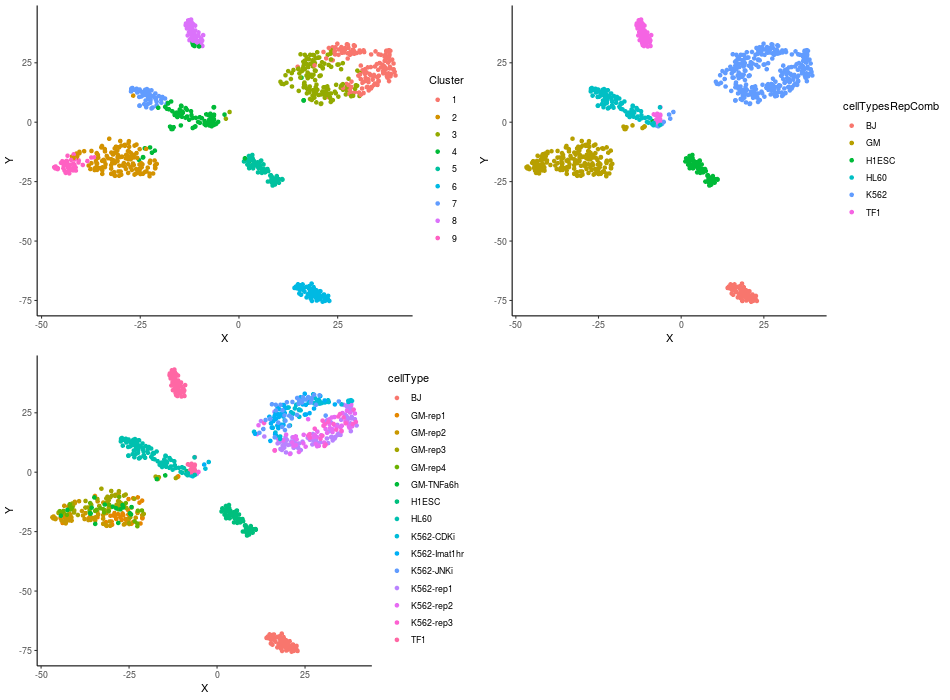

In [41]:
%%R -w 950 -h 700
df<-data.frame(X=tsNE_out_2PCs$X,Y=tsNE_out_2PCs$Y,  
               Cluster = as.factor(my.clusters), 
               cellType = as.factor(cellTypes),
               cellTypesRepComb = as.factor(cellTypesRepComb))
p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Cluster")) + geom_point() + theme_classic()
p2 <- ggplot(df, aes_string(x="X",y ="Y", color="cellType")) + geom_point() + theme_classic()
p3 <- ggplot(df, aes_string(x="X",y ="Y", color="cellTypesRepComb")) + geom_point() + theme_classic()
cellTypesRepComb

multiplot(p1,p2,p3,cols=2)

The clusters nicely overlays on the t-SNE visualization. Inspecting the t-SNE plots we can see that some of the cell-types are getting more than one cluster. As mentioned by [Weber & Robinson et. al. Cytometry A. 2016 Dec;89(12):1084-1096](https://www.ncbi.nlm.nih.gov/pubmed/27992111), it is better to start with slightly higher number of clusters and then using expert knowledge to manually merge clusters with similar phenotypes. We can merge those clusters by visually inspecting it or by characterizing the peaks associated with each cluster. In this notebook we took the first approach.

# Characterizing the cell types

Now we will try to characterize the different cell types using the differentially accessible peaks. For this we identify the differentially accessible peaks associated with each cell-type and then characterize the cells based on the motifs associated with the peaks as well as the functional analysis based on `Great`.

## Detecting motifs for cell-types (K562)
We now identify the motifs associated with K562 cells. For this we first calculate Differential Accessibility to find out the peaks that are differentially accessible in K562 vs all cells.

We first identify the K562 cells and the cells that are not K562

In [48]:
%%R
c1CellName <- rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) == 'K562',])
c2CellName <-  rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) != 'K562',])
c1CountData <- cdFiltTop[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTop[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))

We prepare for the Differential Accessibility analysis

In [52]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTop[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTop[,1],'_',cdFiltTop[,2],'_',cdFiltTop[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
 C1  C2 
278 462 


In [53]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.022394 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [131]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 3945    7


There are 3945 peaks that are significantly differentially accessible in K562 cells compared with all other cells indicating that these can be marker peaks for these cells.

In [132]:
%%R
head(significantDEpeaks)

                           Chr     Start       end information.gain
chr22_22899001_22902550  chr22  22899001  22902550        0.1796699
chr9_133999990_134002602  chr9 133999990 134002602        0.1440533
chr22_22873690_22876012  chr22  22873690  22876012        0.1297814
chr22_22107612_22111638  chr22  22107612  22111638        0.1238037
chr22_21995184_21998492  chr22  21995184  21998492        0.1234496
chr9_134147539_134155387  chr9 134147539 134155387        0.1223317
                         rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr22_22899001_22902550      0.5179856   0.025974026       4.317770
chr9_133999990_134002602     0.5611511   0.077922078       2.848285
chr22_22873690_22876012      0.3417266   0.004329004       6.302664
chr22_22107612_22111638      0.4316547   0.036796537       3.552236
chr22_21995184_21998492      0.6618705   0.173160173       1.934442
chr9_134147539_134155387     0.6510791   0.166666667       1.965867


In [140]:
%%R
sigK562 <- significantDEpeaks

In [177]:
%%R
dim(sigK562)

[1] 3945    7


## Annotating peaks

We annotate the these peaks. We use `marge`, an `R` package working as an API for `homer` to annotate the motifs associated with these peaks.

In [142]:
%%R
dat <- as_tibble(sigK562[, c(1:3)])

### Find Motifs Across the Genome
From the highly open regions we now find the enriched _de  novo_ and/or _known motifs_ via the `find_motifs_genome()`
function. This function makes a connection to the HOMER utility `findMotifsGenome.pl`. A de novo and known motifs enrichment analysis is run on the test regions loaded prior, and writes results to the designated path directory. 

In [178]:
%%R
## Create a temporary directory to write results
## This directory is erased once R session is closed
#results_dir <-tempfile(pattern ='test-dir_')
results_dir <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/K562'

In [179]:
%%R
find_motifs_genome(dat,path = results_dir, genome ='hg38', overwrite = TRUE, motif_length=16)

### Load Denovo and Known Motif Enrichment Results
By default `HOMER` produces two distinct files for _de novo_ and _known motif_ enrichments within the results
directory, in `homerMotifs.all.motif` and `knownResults.txt` file respectively. In `marger`, these results can be
read in using the respective `read_*_results()` functions, where * is either denovo or known.

In [180]:
%%R
known  <- read_known_results(path = '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/K562/knownResults.txt'
                             , homer_dir = FALSE)
#denovo <- read_denovo_results(path = results_dir, homer_dir = TRUE)

In [181]:
%%R
known

# A tibble: 363 x 14
   motif_name  motif_family experiment accession database consensus log_p_value
   <chr>       <chr>        <chr>      <chr>     <chr>    <chr>           <dbl>
 1 ZNF382      Zf           HEK293-ZN… GSE58341  Homer    GNCTGTAS…           3
 2 Egr2        Zf           Thymocyte… GSE34254  Homer    NGCGTGGG…           3
 3 ETS1        ETS          Jurkat-ET… GSE17954  Homer    ACAGGAAG…           3
 4 Ets1-distal ETS          CD4+-PolI… Barski_e… Homer    MACAGGAA…           2
 5 PU.1        ETS          ThioMac-P… GSE21512  Homer    AGAGGAAG…           2
 6 STAT6       Stat         Macrophag… GSE38377  Homer    TTCCKNAG…           2
 7 Etv2        ETS          ES-ER71-C… GSE59402  Homer(0… NNAYTTCC…           1
 8 ERG         ETS          VCaP-ERG-… GSE14097  Homer    ACAGGAAG…           1
 9 RARg        NR           ES-RARg-C… GSE30538  Homer    AGGTCAAG…           1
10 RBPJ:Ebox   ?,bHLH       Panc1-Rbp… GSE47459  Homer    GGGRAARR…           1
# ... with 353 more

In [151]:
%%R
write.csv(data.frame(motifName=known[[1]], log_p_value=known[[7]], FDR=known[[8]]),'K562_motifs.csv')

## Disease ontology analysis

We now do a disease ontology analysis with the K562 significant peaks.

In [182]:
%%R
sigK562Sel <- sigK562[sigK562$log2FoldChange>2,]

In [183]:
%%R
bedg1 = sigK562Sel
jobg1 = submitGreatJob(bedg1, version = "3.0", species='hg19')

In [184]:
%%R
tbDisG1 = getEnrichmentTables(jobg1, ontolog="Disease Ontology")
dftbDisG1 = data.frame(Name = tbDisG1[[1]][,2], Binom_p=-log10(tbDisG1[[1]][,8]))

In [186]:
%%R
dftbDisG1[1:10,]

                         Name  Binom_p
1           lymphoid leukemia 21.05432
2            myeloid leukemia 18.18818
3     alveolar echinococcosis 18.02069
4    chronic myeloid leukemia 17.93534
5              echinococcosis 16.62967
6  gallbladder adenocarcinoma 15.57111
7                    leukemia 13.48804
8      lymphoblastic leukemia 13.04917
9         hemorrhagic disease 12.62245
10  blood coagulation disease 12.24694


We know that __K562__ cells are the human myelogenous leukemia cell lines. This is the exact disease ontology picked up from the first 2 disease ontology in the GREAT analysis confirming our pipeline's efficieny in characterizing the cells correcting. 

## Detecting motifs for cell-types (H1ESC)
We now identify the motifs associated with H1ESC cells.

Agia, we first identify the H1ESC cells and the cells that are not H1ESC

In [152]:
%%R
c1CellName <- rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) == 'H1ESC',])
c2CellName <-  rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) != 'H1ESC',])
c1CountData <- cdFiltTop[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTop[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))

We prepare for the Differential Accessibility analysis

In [153]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTop[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTop[,1],'_',cdFiltTop[,2],'_',cdFiltTop[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
 C1  C2 
 60 680 


In [154]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.069025 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [155]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 617   7


There are 617 peaks that are significantly differentially accessible in H1ESC cells compared with all other cells indicating that these can be marker peaks for these cells.

In [156]:
%%R
head(significantDEpeaks)

                          Chr     Start       end information.gain
chr8_105235368_105236506 chr8 105235368 105236506       0.04884215
chr8_17270582_17271344   chr8  17270582  17271344       0.04852606
chr3_67039181_67039625   chr3  67039181  67039625       0.04487596
chr5_140345779_140347966 chr5 140345779 140347966       0.04240195
chr1_95391852_95393214   chr1  95391852  95393214       0.04156323
chr2_111489796_111490785 chr2 111489796 111490785       0.04062765
                         rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr8_105235368_105236506     0.3166667   0.010294118       4.943073
chr8_17270582_17271344       0.2500000   0.001470588       7.409391
chr3_67039181_67039625       0.2333333   0.001470588       7.309855
chr5_140345779_140347966     0.3000000   0.013235294       4.502500
chr1_95391852_95393214       0.3500000   0.026470588       3.724893
chr2_111489796_111490785     0.2500000   0.005882353       5.409391


In [159]:
%%R
sigH1ESC <- significantDEpeaks

In [160]:
%%R
dim(sigH1ESC)

[1] 617   7


## Annotating peaks

We annotate the these peaks. We use `marge`, an `R` package working as an API for `homer` to annotate the motifs associated with these peaks.

In [161]:
%%R
dat <- as_tibble(sigH1ESC[, c(1:3)])

### Find Motifs Across the Genome
From the highly open regions we now find the enriched _de  novo_ and/or _known motifs_ via the `find_motifs_genome()`
function. This function makes a connection to the HOMER utility `findMotifsGenome.pl`. A de novo and known motifs enrichment analysis is run on the test regions loaded prior, and writes results to the designated path directory. 

In [162]:
%%R
## Create a temporary directory to write results
## This directory is erased once R session is closed
#results_dir <-tempfile(pattern ='test-dir_')
results_dir <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/H1ESC'

In [163]:
%%R
find_motifs_genome(dat,path = results_dir, genome ='hg38', overwrite = TRUE)

### Load Denovo and Known Motif Enrichment Results
By default `HOMER` produces two distinct files for _de novo_ and _known motif_ enrichments within the results
directory, in `homerMotifs.all.motif` and `knownResults.txt` file respectively. In `marger`, these results can be
read in using the respective `read_*_results()` functions, where * is either denovo or known.

In [164]:
%%R
known  <- read_known_results(path = '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/H1ESC/knownResults.txt'
                             , homer_dir = FALSE)
#denovo <- read_denovo_results(path = results_dir, homer_dir = TRUE)

In [165]:
%%R
known

# A tibble: 363 x 14
   motif_name motif_family experiment  accession database consensus log_p_value
   <chr>      <chr>        <chr>       <chr>     <chr>    <chr>           <dbl>
 1 Tcf21      bHLH         ArterySmoo… GSE61369  Homer    NAACAGCT…           2
 2 Myf5       bHLH         GM-Myf5-Ch… GSE24852  Homer    BAACAGCT…           2
 3 Tcf12      bHLH         GM12878-Tc… GSE32465  Homer    VCAGCTGY…           1
 4 Six2       Homeobox     NephronPro… GSE39837  Homer    GWAAYHTG…           1
 5 MyoD       bHLH         Myotube-My… GSE21614  Homer    RRCAGCTG…           1
 6 ELF5       ETS          T47D-ELF5-… GSE30407  Homer    ACVAGGAA…           1
 7 E2A        bHLH         proBcell-E… GSE21978  Homer    DNRCAGCT…           1
 8 Tbx5       T-box        HL1-Tbx5.b… GSE21529  Homer    AGGTGTCA            1
 9 PPARE      NR,DR1       3T3L1-Ppar… GSE13511  Homer    TGACCTTT…           1
10 RFX        HTH          K562-RFX3-… SRA012198 Homer    CGGTTGCC…           1
# ... with 353 more

In [166]:
%%R
write.csv(data.frame(motifName=known[[1]], log_p_value=known[[7]], FDR=known[[8]]),'H1ESC_motifs.csv')

## Detecting motifs for cell-types (BJ)
Now, we identify the motifs associated with BJ cells.

Like before, we first identify the BJ cells and the cells that are not BJ

In [167]:
%%R
c1CellName <- rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) == 'BJ',])
c2CellName <-  rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) != 'BJ',])
c1CountData <- cdFiltTop[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTop[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))

We prepare for the Differential Accessibility analysis

In [168]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTop[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTop[,1],'_',cdFiltTop[,2],'_',cdFiltTop[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
 C1  C2 
 56 684 


In [169]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.085277 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [170]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 1172    7


There are 1172 peaks that are significantly differentially accessible in BJ cells compared with all other cells indicating that these can be marker peaks for these cells.

In [171]:
%%R
head(significantDEpeaks)

                           Chr     Start       end information.gain
chr7_73309035_73309793    chr7  73309035  73309793       0.07760495
chr6_117761914_117762805  chr6 117761914 117762805       0.06441182
chr20_49982694_49983371  chr20  49982694  49983371       0.06213293
chr1_99922886_99923706    chr1  99922886  99923706       0.05826243
chr1_44793385_44793943    chr1  44793385  44793943       0.05826243
chr18_26734605_26735364  chr18  26734605  26735364       0.05826243
                         rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr7_73309035_73309793       0.3928571   0.001461988       8.069929
chr6_117761914_117762805     0.3750000   0.005847953       6.002815
chr20_49982694_49983371      0.3750000   0.007309942       5.680887
chr1_99922886_99923706       0.3214286   0.002923977       6.780423
chr1_44793385_44793943       0.3214286   0.002923977       6.780423
chr18_26734605_26735364      0.3214286   0.002923977       6.780423


In [172]:
%%R
sigBJ <- significantDEpeaks

In [173]:
%%R
dim(sigBJ)

[1] 1172    7


## Annotating peaks

We annotate the these peaks. We use `marge`, an `R` package working as an API for `homer` to annotate the motifs associated with these peaks.

In [174]:
%%R
dat <- as_tibble(sigBJ[, c(1:3)])

### Find Motifs Across the Genome
From the highly open regions we now find the enriched _de  novo_ and/or _known motifs_ via the `find_motifs_genome()`
function. This function makes a connection to the HOMER utility `findMotifsGenome.pl`. A de novo and known motifs enrichment analysis is run on the test regions loaded prior, and writes results to the designated path directory. 

In [175]:
%%R
## Create a temporary directory to write results
## This directory is erased once R session is closed
#results_dir <-tempfile(pattern ='test-dir_')
results_dir <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/BJ'

In [176]:
%%R
find_motifs_genome(dat,path = results_dir, genome ='hg38', overwrite = TRUE)

### Load Denovo and Known Motif Enrichment Results
By default `HOMER` produces two distinct files for _de novo_ and _known motif_ enrichments within the results
directory, in `homerMotifs.all.motif` and `knownResults.txt` file respectively. In `marger`, these results can be
read in using the respective `read_*_results()` functions, where * is either denovo or known.

In [ ]:
%%R
known  <- read_known_results(path = '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/BJ/knownResults.txt'
                             , homer_dir = FALSE)
#denovo <- read_denovo_results(path = results_dir, homer_dir = TRUE)

In [ ]:
%%R
known

In [74]:
%%R
write.csv(known[[1]], 'BJ_motifs.csv')

## Biological process analysis

We now do a biological proces analysis associated with the BJ significant peaks.

In [243]:
%%R
sigBJSel <- sigBJ[sigBJ$log2FoldChange>2,]

In [244]:
%%R
bedg1 = sigBJSel
jobg1 = submitGreatJob(bedg1, version = "3.0", species='hg19')

In [245]:
%%R
tbDisG1 = getEnrichmentTables(jobg1, ontolog="GO Biological Process")
dftbDisG1 = data.frame(Name = tbDisG1[[1]][,2], Binom_p=-log10(tbDisG1[[1]][,8]))

In [246]:
%%R
dftbDisG1[1:10,]

                                        Name  Binom_p
1           regulation of cell communication 17.26924
2                    regulation of signaling 16.97066
3          regulation of signal transduction 16.94500
4                         response to stress 16.78951
5  negative regulation of biological process 16.73278
6        regulation of programmed cell death 16.30698
7            regulation of apoptotic process 16.26233
8         regulation of response to stimulus 15.75750
9    negative regulation of cellular process 15.30380
10                  regulation of cell death 15.28546


As the BJ cells are from skin or foreskin tissue it is heaviliy involved with the regulation of cell-singalling process.

## Detecting motifs for cell-types (TF-1)
Now, we identify the motifs associated with TF-1 cells.

Like before, we first identify the TF-1 cells and the cells that are not TF-1

In [247]:
%%R
c1CellName <- rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) == 'TF1',])
c2CellName <-  rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) != 'TF1',])
c1CountData <- cdFiltTop[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTop[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))

We prepare for the Differential Accessibility analysis

In [248]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTop[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTop[,1],'_',cdFiltTop[,2],'_',cdFiltTop[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
 C1  C2 
 64 676 


In [249]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.164782 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [250]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 676   7


There are 676 peaks that are significantly differentially accessible in TF-1 cells compared with all other cells indicating that these can be marker peaks for these cells.

In [251]:
%%R
head(significantDEpeaks)

                          Chr    Start      end information.gain rawMeanGroup1
chr19_38754356_38756643 chr19 38754356 38756643       0.10894056      0.671875
chr19_39182621_39184937 chr19 39182621 39184937       0.08839462      0.562500
chr19_39164751_39168157 chr19 39164751 39168157       0.07570920      0.609375
chr19_38809674_38812785 chr19 38809674 38812785       0.07362591      0.468750
chr15_80852914_80853833 chr15 80852914 80853833       0.06927068      0.406250
chr19_38510660_38511315 chr19 38510660 38511315       0.06891305      0.328125
                        rawMeanGroup2 log2FoldChange
chr19_38754356_38756643    0.03550296       4.242182
chr19_39182621_39184937    0.02810651       4.322877
chr19_39164751_39168157    0.06065089       3.328730
chr19_38809674_38812785    0.02071006       4.500415
chr15_80852914_80853833    0.01183432       5.101319
chr19_38510660_38511315    0.00147929       7.793197


In [252]:
%%R
sigTF1 <- significantDEpeaks

In [253]:
%%R
dim(sigTF1)

[1] 676   7


## Annotating peaks

We annotate the these peaks. We use `marge`, an `R` package working as an API for `homer` to annotate the motifs associated with these peaks.

In [254]:
%%R
dat <- as_tibble(sigTF1[, c(1:3)])

### Find Motifs Across the Genome
From the highly open regions we now find the enriched _de  novo_ and/or _known motifs_ via the `find_motifs_genome()`
function. This function makes a connection to the HOMER utility `findMotifsGenome.pl`. A de novo and known motifs enrichment analysis is run on the test regions loaded prior, and writes results to the designated path directory. 

In [255]:
%%R
## Create a temporary directory to write results
## This directory is erased once R session is closed
#results_dir <-tempfile(pattern ='test-dir_')
results_dir <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/TF1'

In [256]:
%%R
find_motifs_genome(dat,path = results_dir, genome ='hg38', overwrite = TRUE)

### Load Denovo and Known Motif Enrichment Results
By default `HOMER` produces two distinct files for _de novo_ and _known motif_ enrichments within the results
directory, in `homerMotifs.all.motif` and `knownResults.txt` file respectively. In `marger`, these results can be
read in using the respective `read_*_results()` functions, where * is either denovo or known.

In [257]:
%%R
known  <- read_known_results(path = '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/TF1/knownResults.txt'
                             , homer_dir = FALSE)
#denovo <- read_denovo_results(path = results_dir, homer_dir = TRUE)

In [258]:
%%R
known

# A tibble: 363 x 14
   motif_name motif_family  experiment accession database consensus log_p_value
   <chr>      <chr>         <chr>      <chr>     <chr>    <chr>           <dbl>
 1 Mef2c      MADS          GM12878-M… GSE32465  Homer    DCYAAAAA…           2
 2 Fox:Ebox   Forkhead,bHLH Panc1-Fox… GSE47459  Homer    NNNVCTGW…           2
 3 ZNF519     Zf            HEK293-ZN… GSE58341  Homer    GAGSCCGA…           1
 4 Foxo1      Forkhead      RAW-Foxo1… Fan_et_a… Homer    CTGTTTAC            1
 5 Nr5a2      NR            Pancreas-… GSE34295  Homer    BTCAAGGT…           1
 6 ERE        NR,IR3        MCF7-ERa-… Unpublis… Homer    VAGGTCAC…           1
 7 Oct4:Sox17 POU,Homeobox… F9-Sox17-… GSE44553  Homer    CCATTGTA…           1
 8 PGR        NR            EndoStrom… GSE69539  Homer    AAGAACAT…           1
 9 Oct2       POU,Homeobox  Bcell-Oct… GSE21512  Homer    ATATGCAA…           1
10 TEAD4      TEA           Tropoblas… GSE37350  Homer    CCWGGAAT…           1
# ... with 353 more

In [259]:
%%R
write.csv(known[[1]], 'TF1_motifs.csv')

## Disease Ontology analysis

We now do a disease ontology analysis associated with the TF1 significant peaks.

In [260]:
%%R
sigTF1Sel <- sigTF1[sigTF1$log2FoldChange>2,]

In [261]:
%%R
bedg1 = sigTF1Sel
jobg1 = submitGreatJob(bedg1, version = "3.0", species='hg19')

In [264]:
%%R
tbDisG1 = getEnrichmentTables(jobg1, ontolog="GO Biological Process")
dftbDisG1 = data.frame(Name = tbDisG1[[1]][,2], Binom_p=-log10(tbDisG1[[1]][,8]))

In [265]:
%%R
dftbDisG1[1:10,]

                                                          Name   Binom_p
1                                    regulation of endocytosis 10.463048
2                           positive regulation of pinocytosis  8.882493
3                                    regulation of pinocytosis  8.705260
4   positive regulation of sodium:hydrogen antiporter activity  7.031639
5            regulation of sodium:hydrogen antiporter activity  6.345670
6                                          response to hypoxia  6.231737
7  negative regulation of calcium-dependent cell-cell adhesion  6.205563
8                          response to decreased oxygen levels  6.053775
9                     regulation of vesicle-mediated transport  5.921590
10                                   response to oxygen levels  5.590102


## Detecting motifs for cell-types (HL60)
Now, we identify the motifs associated with HL60 cells.

Again we first identify the HL60 cells and the cells that are not HL60

In [266]:
%%R
c1CellName <- rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) == 'HL60',])
c2CellName <-  rownames(annotFilt[sub('-.*','',annotFilt$CellInfo) != 'HL60',])
c1CountData <- cdFiltTop[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTop[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))

We prepare for the Differential Accessibility analysis

In [267]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTop[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTop[,1],'_',cdFiltTop[,2],'_',cdFiltTop[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
 C1  C2 
 92 648 


In [268]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.124501 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [269]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 562   7


There are 562 peaks that are significantly differentially accessible in HL60 cells compared with all other cells indicating that these can be marker peaks for these cells.

In [270]:
%%R
head(significantDEpeaks)

                          Chr     Start       end information.gain
chr8_130677121_130679694 chr8 130677121 130679694       0.08531696
chr8_130566009_130568572 chr8 130566009 130568572       0.07303881
chr8_126517715_126520158 chr8 126517715 126520158       0.06547579
chr8_130558448_130561453 chr8 130558448 130561453       0.06025955
chr8_126524439_126527264 chr8 126524439 126527264       0.05439976
chr8_126440866_126448872 chr8 126440866 126448872       0.05033241
                         rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr8_130677121_130679694     0.3260870   0.001543210       7.723179
chr8_130566009_130568572     0.3369565   0.009259259       5.185522
chr8_126517715_126520158     0.3695652   0.023148148       3.996860
chr8_130558448_130561453     0.3804348   0.032407407       3.553254
chr8_126524439_126527264     0.3369565   0.026234568       3.683022
chr8_126440866_126448872     0.7934783   0.324074074       1.291867


In [271]:
%%R
sigHL60 <- significantDEpeaks

In [272]:
%%R
dim(sigHL60)

[1] 562   7


## Annotating peaks

We annotate the these peaks. We use `marge`, an `R` package working as an API for `homer` to annotate the motifs associated with these peaks.

In [273]:
%%R
dat <- as_tibble(sigHL60[, c(1:3)])

### Find Motifs Across the Genome
From the highly open regions we now find the enriched _de  novo_ and/or _known motifs_ via the `find_motifs_genome()`
function. This function makes a connection to the HOMER utility `findMotifsGenome.pl`. A de novo and known motifs enrichment analysis is run on the test regions loaded prior, and writes results to the designated path directory. 

In [274]:
%%R
## Create a temporary directory to write results
## This directory is erased once R session is closed
#results_dir <-tempfile(pattern ='test-dir_')
results_dir <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/HL60'

In [275]:
%%R
find_motifs_genome(dat,path = results_dir, genome ='hg38', overwrite = TRUE)

### Load Denovo and Known Motif Enrichment Results
By default `HOMER` produces two distinct files for _de novo_ and _known motif_ enrichments within the results
directory, in `homerMotifs.all.motif` and `knownResults.txt` file respectively. In `marger`, these results can be
read in using the respective `read_*_results()` functions, where * is either denovo or known.

In [276]:
%%R
known  <- read_known_results(path = '/home/mqbsxsm2/Rna-seq_Data-Analysis/ScAsAT_notebooks_Updated/HOMER_results/HL60/knownResults.txt'
                             , homer_dir = FALSE)
#denovo <- read_denovo_results(path = results_dir, homer_dir = TRUE)

In [277]:
%%R
known

# A tibble: 363 x 14
   motif_name motif_family experiment  accession database consensus log_p_value
   <chr>      <chr>        <chr>       <chr>     <chr>    <chr>           <dbl>
 1 CLOCK      bHLH         Liver-Cloc… GSE39860  Homer    GHCACGTG            2
 2 STAT6      Stat         Macrophage… GSE38377  Homer    TTCCKNAG…           1
 3 Sp1        Zf           Promoter    NA        Homer    GGCCCCGC…           1
 4 E2F4       E2F          K562-E2F4-… GSE31477  Homer    GGCGGGAA…           1
 5 ISRE       IRF          ThioMac-LP… GSE23622  Homer    AGTTTCAS…           1
 6 c-Myc      bHLH         LNCAP-cMyc… Unpublis… Homer    VCCACGTG            1
 7 Olig2      bHLH         Neuron-Oli… GSE30882  Homer    RCCATMTG…           1
 8 Tbet       T-box        CD8-Tbet-C… GSE33802  Homer    AGGTGTGA…           1
 9 IRF1       IRF          PBMC-IRF1-… GSE43036  Homer    GAAAGTGA…           1
10 FOXM1      Forkhead     MCF7-FOXM1… GSE72977  Homer    TRTTTACT…           1
# ... with 353 more

In [74]:
%%R
write.csv(known[[1]], 'HL60_motifs.csv')

## Biological process analysis

We now do a biological proces analysis associated with the BJ significant peaks.

In [278]:
%%R
sigHL60Sel <- sigHL60[sigHL60$log2FoldChange>2,]

In [279]:
%%R
bedg1 = sigHL60Sel
jobg1 = submitGreatJob(bedg1, version = "3.0", species='hg19')

In [213]:
%%R
tbDisG1 = getEnrichmentTables(jobg1, ontolog="GO Biological Process")
dftbDisG1 = data.frame(Name = tbDisG1[[1]][,2], Binom_p=-log10(tbDisG1[[1]][,8]))

In [214]:
%%R
dftbDisG1[1:10,]

                                        Name  Binom_p
1  negative regulation of biological process 16.36668
2          regulation of signal transduction 16.31961
3           regulation of cell communication 16.16977
4                    regulation of signaling 15.88796
5        regulation of programmed cell death 15.63753
6            regulation of apoptotic process 15.63339
7    negative regulation of cellular process 15.26132
8                         response to stress 15.14043
9                   regulation of cell death 14.54183
10                      response to wounding 14.39194


As the BJ cells are from skin or foreskin tissue it is heaviliy involved with the regulation of cell-singalling process.